# Step 3: Build your data tensor

Use this notebook to arrange your normalized data into tensor format using the [xarray](https://docs.xarray.dev/en/stable/) package. 

Please note that your input data should already have been normalized, and should be saved in a csv file using [tidy format](https://tidyr.tidyverse.org/articles/tidy-data.html). At a minimum your input csv should have five columns:
1. A column that corresponds to the first mode of your tensor. In metatranscriptomic data this column might indicate gene ID.
    - This first mode should generally be the longest in your tensor, and the one that corresponds to the variable you want clustered (e.g. genes in the case of metatranscriptomics data). The sparsity penalty (`lambda`) will be applied to this mode.
1. A column that corresponds to the second mode of your tensor. In metatranscriptomic data this column might indicate taxon ID.
1. A column that corresponds to the third mode of your tensor. This column should indicate sample ID.
    - **IMPORTANT: Sample IDs should be identical for different replicates of the same sample condition (see example below).**
1. A column that indicates the replicate ID of the sample.
1. A column that corresponds to the normalized data. If you normalized your data with sctransform (as laid out in jupyter notebook [2-normalize-sctransform.ipynb](https://github.com/blasks/barnacle-boilerplate/blob/main/2-normalize-sctransform.ipynb), this column will correspond to the residual.

Here's a snippet of how an example csv might be arranged:

| gene_id | taxon_id   | sample_id | replicate | residual |
|---------|------------|-----------|-----------|----------|
| K03839  | P. marinus | sample1   | A         | 3.02     |
| K03839  | P. marinus | sample1   | B         | 3.31     |
| K03839  | P. marinus | sample1   | C         | 3.18     |
| K03839  | P. marinus | sample2   | A         | -1.24    |
| ...     | ...        | ...       | ...       | ...      |
| K03320  | S. marinus | sample9   | C         | 0.05     |


In [1]:
# imports

import itertools
import os
import pandas as pd
import plotly.express as px
import random
import xarray as xr


In [2]:
# USER INPUTS -- edit these variables as needed

datapath = 'data/barnacle/normalization/normalized-residuals.csv' # Enter the filepath of your input data file
outdir = 'data' # Enter the filepath of the output directory where you want files saved
mode0 = 'KOfam' # Enter the column name that corresponds to the first mode of your tensor (e.g. gene mode)
mode1 = 'phylum' # Enter the column name that corresponds to the second mode of your tensor (e.g. taxon mode)
mode2 = 'sample_name' # Enter the column name that corresponds to the third mode of your tensor (e.g. sample mode)
rep = 'replicate' # Enter the column name that corresponds to replicate IDs
data = 'residual' # Enter the column name that corresponds to your normalized data

# check output directory exists
if not os.path.exists(outdir):
    os.makedirs(outdir)

# read in csv
df = pd.read_csv(datapath)

# check column names match inputs
for column in [mode0, mode1, mode2, rep, data]:
    if column not in df.columns:
        raise Exception(f'Column name "{column}" not found in headers of file {datapath}')

# make column for combined sample-replicate ID
df['sample_replicate_id'] = df[mode2].astype(str) + '_' + df[rep].astype(str)

# tidy up dataframe
df = df[[mode0, mode1, 'sample_replicate_id', mode2, rep, data]].rename(columns={mode2: 'sample_id', rep: 'replicate_id', data: 'data'})

df


KOfam           phylum sample_replicate_id        sample_id  \
0        K00001  Bacillariophyta   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1   
1        K00002  Bacillariophyta   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1   
2        K00003  Bacillariophyta   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1   
3        K00004  Bacillariophyta   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1   
4        K00006  Bacillariophyta   G3.UW.ALL.L25S1_A  G3.UW.ALL.L25S1   
...         ...              ...                 ...              ...   
1284467  K26159    Pelagophyceae   G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2   
1284468  K26163    Pelagophyceae   G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2   
1284469  K26165    Pelagophyceae   G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2   
1284470  K26167    Pelagophyceae   G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2   
1284471  K26171    Pelagophyceae   G3.UW.ALL.L40S2_C  G3.UW.ALL.L40S2   

        replicate_id          data  
0                  A -9.222961e-13  
1                  A  2.092099e+00  
2                  A -1.128763e+00  
3                  A -1.635693e-02  
4                  A -6.474356e-01  
...              ...           ...  
1284467            C -1.360729e-01  
1284468            C  1.537219e+00  
1284469            C  6.104757e-01  
1284470            C  8.077639e-01  
1284471            C -3.022025e-01  

[1284472 rows x 6 columns]

In [3]:
# organize dataset into xarray.Dataset tensor

# create xr.Dataset
sample_df = df[['sample_replicate_id', 'sample_id', 'replicate_id']].drop_duplicates()
ds = xr.Dataset({
    'data': xr.DataArray.from_series(df.set_index([mode0, mode1, 'sample_replicate_id'])['data']), 
    'sample_id': xr.DataArray.from_series(sample_df.set_index('sample_replicate_id')['sample_id']), 
    'replicate_id': xr.DataArray.from_series(sample_df.set_index('sample_replicate_id')['replicate_id'])
})

# fill missing values with zeros
ds = ds.fillna(0)

# save to output directory
out_file = f'{outdir}/data-tensor.nc'
if not os.path.isfile(out_file):
    ds.to_netcdf(out_file)
    print(f'Tensor dataset ds saved as {out_file}')
else:
    choice = ''
    while choice not in ['y', 'n']:
        choice = input(f'WARNING: The file {out_file} already exists. Would you like to overwrite? (Y/N):').lower().strip()
    if choice == 'y':
        ds.to_netcdf(out_file)
        print(f'Tensor dataset ds saved as {out_file}')
    elif choice == 'n':
        print('Tensor dataset ds not saved.')

# show Dataset
ds


Tensor dataset ds saved as data/data-tensor.nc


<xarray.Dataset> Size: 19MB
Dimensions:              (KOfam: 10829, phylum: 8, sample_replicate_id: 28)
Coordinates:
  * KOfam                (KOfam) object 87kB 'K00001' 'K00002' ... 'K26180'
  * phylum               (phylum) object 64B 'Bacillariophyta' ... 'Pelagophy...
  * sample_replicate_id  (sample_replicate_id) object 224B 'G3.UW.ALL.L25S1_A...
Data variables:
    data                 (KOfam, phylum, sample_replicate_id) float64 19MB -9...
    sample_id            (sample_replicate_id) object 224B 'G3.UW.ALL.L25S1' ...
    replicate_id         (sample_replicate_id) object 224B 'A' 'B' ... 'B' 'C'

### Visualize data tensor (optional)

Use plotly to visualize your data tensor. 

NOTE: This visualization tool is not intended for tensors larger than a couple of hundred values per mode. If your tensor is larger than that, you must select a subset region you would like to visualize.

In [4]:
# down-select subset of data tensor to visualize

viz_da = ds.data
display(dict(viz_da.sizes))

# choose dimensions
overall_max = 100
dims = {}
for mode in [mode0, mode1, 'sample_replicate_id']:
    maximum = min(viz_da[mode].size, overall_max)
    n = 0
    while n < 1 or n > maximum:
        n = int(input(f'Enter number of {mode} values to show (max = {maximum}):'))
    dims[mode] = n

# choose any data points you'd like to see
# (initialize idx here)

# down-select to only non-zero data
viz_df = viz_da.to_series().reset_index()
viz_df = viz_df[viz_df['data'] != 0]
for mode in [mode0, mode1, 'sample_replicate_id']:
    dims[mode] = min(dims[mode], viz_df[mode].nunique())

# look at the indices in each mode that have the most non-negative values across the other modes
candidate_idx = {mode0: [], mode1: [], 'sample_replicate_id': []}
for mode_pair in itertools.permutations([mode0, mode1, 'sample_replicate_id'], 2):
    count_df = viz_df.groupby(mode_pair[0])[mode_pair[1]].value_counts().sort_values(ascending=False).reset_index()
    for mode in mode_pair:
        candidate_idx[mode].append(set(count_df[mode].unique()[:dims[mode]]))

# pull out consensus indices
idx = {}
for mode in [mode0, mode1, 'sample_replicate_id']:
    idx[mode] = set()
    consensus = set.intersection(*candidate_idx[mode]).difference(idx[mode])
    alternates = set.union(*candidate_idx[mode]).difference(consensus.union(idx[mode]))
    while len(idx[mode]) < dims[mode]:
        idx[mode] = idx[mode].union(set(random.sample(sorted(consensus), min(len(consensus), dims[mode] - len(idx[mode])))))
        idx[mode] = idx[mode].union(set(random.sample(sorted(alternates), dims[mode] - len(idx[mode]))))
    idx[mode] = list(idx[mode])

# down-select data
viz_da = viz_da.sel({mode0: idx[mode0], mode1: idx[mode1], 'sample_replicate_id': idx['sample_replicate_id']})
viz_da

{'KOfam': 10829, 'phylum': 8, 'sample_replicate_id': 28}

Enter number of KOfam values to show (max = 100): 50
Enter number of phylum values to show (max = 8): 8
Enter number of sample_replicate_id values to show (max = 28): 28


<xarray.DataArray 'data' (KOfam: 50, phylum: 8, sample_replicate_id: 28)> Size: 90kB
array([[[-1.64628585e-10,  7.69230203e-01, -2.50929152e-10, ...,
         -7.23918202e-03, -1.12051957e-11, -1.73352168e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 2.81322758e-01, -6.42805859e-03, -1.75183542e-01, ...,
         -5.78476544e-01,  2.40013860e-01,  5.71970806e-01],
        ...,
        [-4.35489078e-11, -5.52214020e-11, -4.55228581e-11, ...,
         -1.19494802e-02, -4.22079785e-11, -3.65491197e-01],
        [-1.47167672e-02, -4.67013672e-01, -7.74064479e-04, ...,
         -1.35010786e+00,  3.01074092e-01,  1.35045724e+00],
        [-6.13419070e-01, -2.74562471e-01, -3.58977187e-01, ...,
         -1.13599447e+00,  3.95033179e-01, -8.67057218e-01]],

       [[-9.05984634e-01, -4.48669437e-01,  3.64424192e+00, ...,
          6.06246040e-01,  1.35700630e+00, -3.82847867e-01],
        [ 1.37078552e+00, -1.20521982e-01,  1.61430650e+00, ...,
         -9.65207398e-01, -7.35669930e-01, -6.67981850e-01],
        [-7.07203366e-02,  1.52861606e+00,  1.16469289e-01, ...,
         -3.83950600e-01, -9.28490014e-02,  1.28734640e+00],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-8.76196152e-01, -6.74484172e-01,  3.20138929e-01, ...,
          1.61504440e+00,  2.25175360e+00, -1.06789192e+00],
        [-3.37561230e-01,  1.76373671e+00, -6.24937610e-01, ...,
         -1.18795420e+00,  1.13316513e-01, -3.78057002e-02],
        [-1.45201496e-02, -1.72506067e+00,  6.97145749e-01, ...,
         -8.37613055e-01,  6.92059773e-01,  2.94454587e-01],
        ...,
        [ 1.57844594e-01, -1.05503774e+00,  2.66180635e+00, ...,
          3.83072471e+00,  4.54346103e+00, -5.83866397e-01],
        [-3.65795076e-02, -1.38375006e+00, -1.27272218e+00, ...,
          8.01074700e-01,  6.83282090e-01, -4.29440631e-01],
        [ 3.20800060e-01, -2.14208923e-02, -8.95054553e-01, ...,
         -4.83708091e-01, -6.40752015e-01, -2.95629764e-01]]])
Coordinates:
  * KOfam                (KOfam) object 400B 'K14842' 'K25166' ... 'K04984'
  * phylum               (phylum) object 64B 'Bacillariophyta' ... 'Haptophyta'
  * sample_replicate_id  (sample_replicate_id) object 224B 'G3.UW.ALL.L31S2_B...

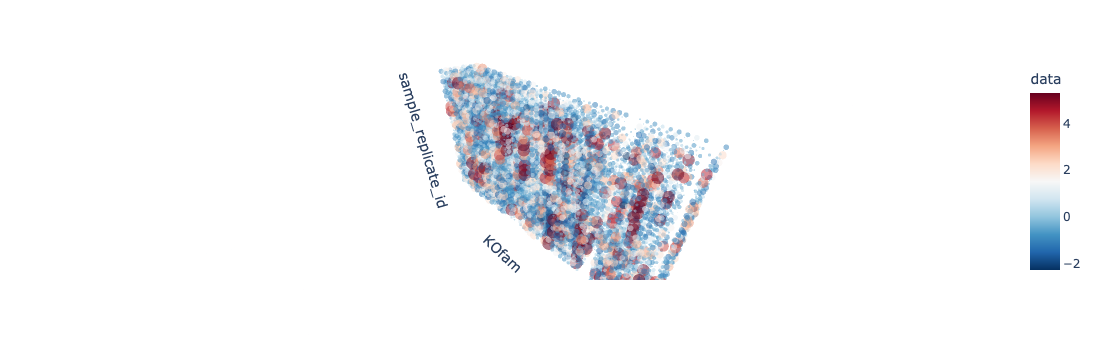

In [5]:
# visualize selected data

# build 3d scatterplot
modes = [mode for mode, _ in sorted(dims.items(), key=lambda item:item[1])]
viz_df = viz_da.to_series().reset_index()
viz_df['abs_data'] = viz_df['data'].abs()
fig = px.scatter_3d(
    viz_df, x=modes[0], y=modes[2], z=modes[1], color='data', size='abs_data', opacity=0.5, 
    color_continuous_scale='RdBu_r', 
)
# update layout to improve readability
fig.update_layout(scene={
    'xaxis': {'showbackground': False, 'showticklabels': False}, 
    'yaxis': {'showbackground': False, 'showticklabels': False}, 
    'zaxis': {'showbackground': False, 'showticklabels': False}, 
    'aspectmode': 'data'}, 
    width=700, paper_bgcolor='#fff', plot_bgcolor='#fff'
)
fig.update_traces(marker={'line': {'color': None, 'width': 0}})
